# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

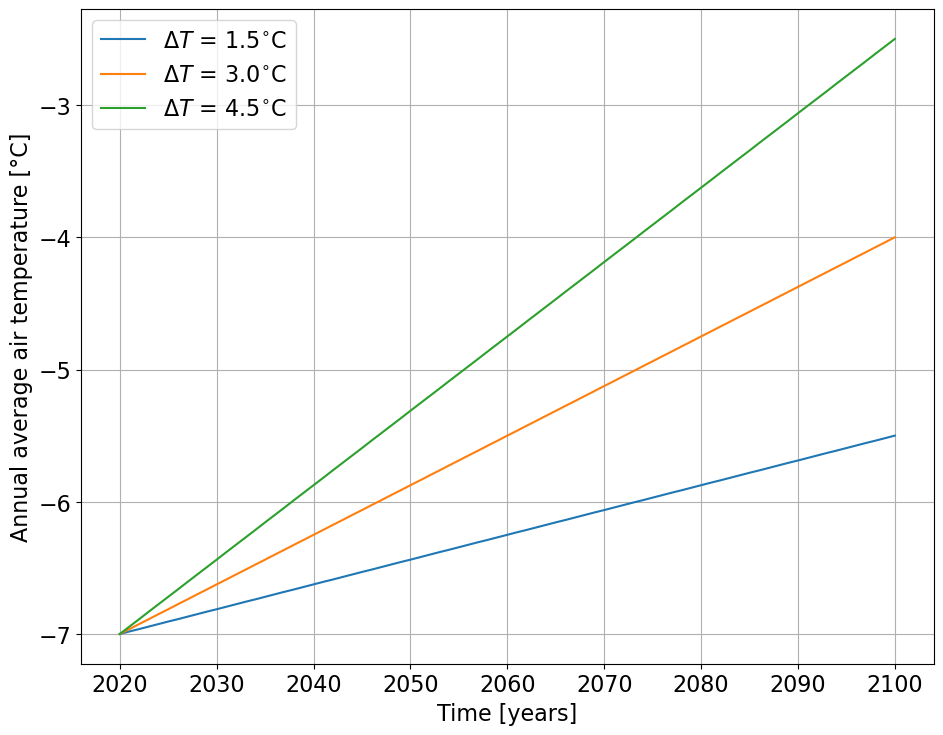

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')
plt.show()

#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
t0 = t_year[0] # 2020
tf = t_year[-1] # 2100

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size # shows size of t(Nt)
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:

# Boundary conditions
Ttopbase = -7.0 # Ttopbase average temp in fairbanks AK
Ttopamp = 35.0  # amplitude of sin function waves
Tbottom = -7.0  # temp at bottom of column

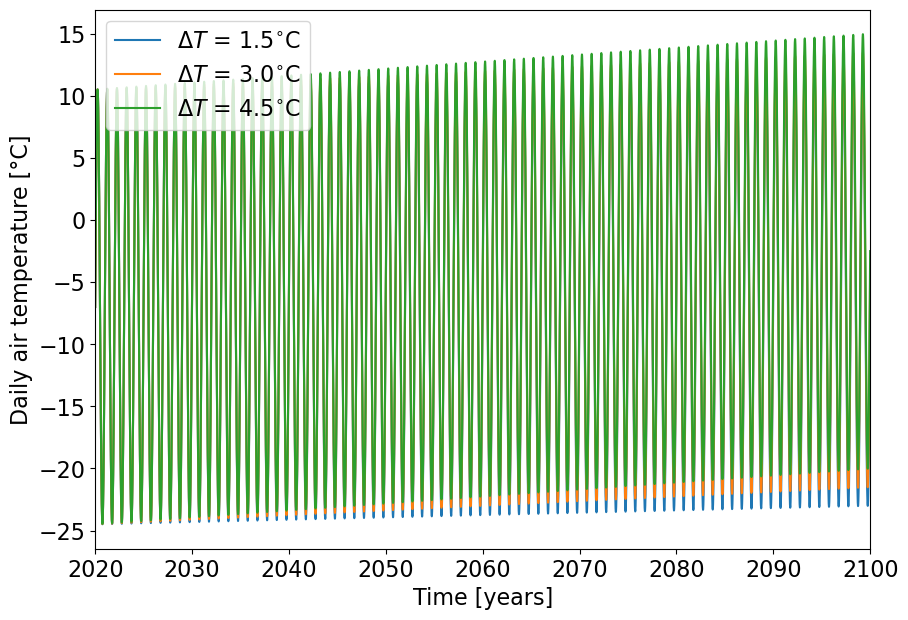

In [6]:
#interperlates values for temp and creates values for all 3 scenrios 
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.xlim([2020,2100])
plt.show()

### 4. Setup Spatial Domain

In [7]:
z = np.arange(dz/2, zs, dz) #middle points of layers 
Nz = z.size #size of z(Nz)
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [8]:
# Calculate diffusivity of permafrost soil
alpha = ks / (rhos * Cs) # Heat capacity of soil/permafrost [J/(kg K)]  # Thermal conductivity of soil/permafrost [W/(m K)] # Bulk density of permafrost [kg/m^3] 
print('Soil diffusivity = '+str(alpha)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
alpha = alpha*(100.0**2)*(24.0*3600.0) #  "**" means exponent
print('Soil diffusivity = '+str(alpha)+' cm^2/day')

s = alpha*dt/(dz**2)
print('Stability criterion '+str(s))
#inital temp vector
Ts0 = Tbottom*np.ones((Nz,1))


Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Stability criterion 0.41081821294077364


### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

### 7. Preallocate Storage Memory

In [9]:
#creates spots for numbers to be pluged into later
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [10]:
for i in np.arange(Nt):     # sets rows in time
    for j in np.arange(Nz): # sets columns in soil 
        
        
        if(i==0): # loop for when i=0
            if(j==0): #for top of boundry 
                #soil layer temp at z-1
                T0zm1_15 = Ttop_15[i] 
                T0zm1_30 = Ttop_30[i]
                T0zm1_45 = Ttop_45[i]
                #soil layer temp at z=0
                T0z_15   = Ts0[j]       
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]   
                #soil layer temp at z+1
                T0zp1_15 = Ts0[j+1]       
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif((j>0) and (j<(Nz-1))): #for between top and bottom
                #soil layer temp at z-1
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                #soil layer temp at z=0
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                #soil layer temp at z+1
                T0zp1_15 = Ts0[j+1]
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif(j==(Nz-1)):           #for bottom of boundry 
                #soil layer temp at z-1
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                #soil layer temp at z=0
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                #soil layer temp at z+1
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom #
        else:                           # loop for all other values
            if(j==0):                   #for top of boundry 
                #soil layer temp at z-1
                T0zm1_15 = Ttop_15[i]
                T0zm1_30 = Ttop_30[i]
                T0zm1_45 = Ttop_45[i]
                #soil layer temp at z=0
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                #soil layer temp at z+1
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif((j>0) and (j<(Nz-1))): #for between top and bottom
                #soil layer temp at z-1
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                #soil layer temp at z=0
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                #soil layer temp at z+1
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif(j==(Nz-1)):             #for bottom of boundry
                #soil layer temp at z-1
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                #soil layer temp at z=0
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                #soil layer temp at z+1
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom
         #computes next temp for soil layers 
        Tz_15 = s*T0zm1_15 + (1.0 - 2.0*s)*T0z_15 + s*T0zp1_15 
        Tz_30 = s*T0zm1_30 + (1.0 - 2.0*s)*T0z_30 + s*T0zp1_30
        Tz_45 = s*T0zm1_45 + (1.0 - 2.0*s)*T0z_45 + s*T0zp1_45
        #stores values for temps in soil(j) and values for time step(i)
        Ts_15[j,i] = Tz_15
        Ts_30[j,i] = Tz_30
        Ts_45[j,i] = Tz_45
        
#print(Tz_15)
#print(T0z_15)
#print(T0zp1_15)
#print(Ts_15)

#print(Tz_30)
#print(T0z_30)
#print(T0zp1_30)
#print(Ts_30)

#print(Tz_45)
#print(T0z_45)
#print(T0zp1_45)
#print(Ts_45)

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.


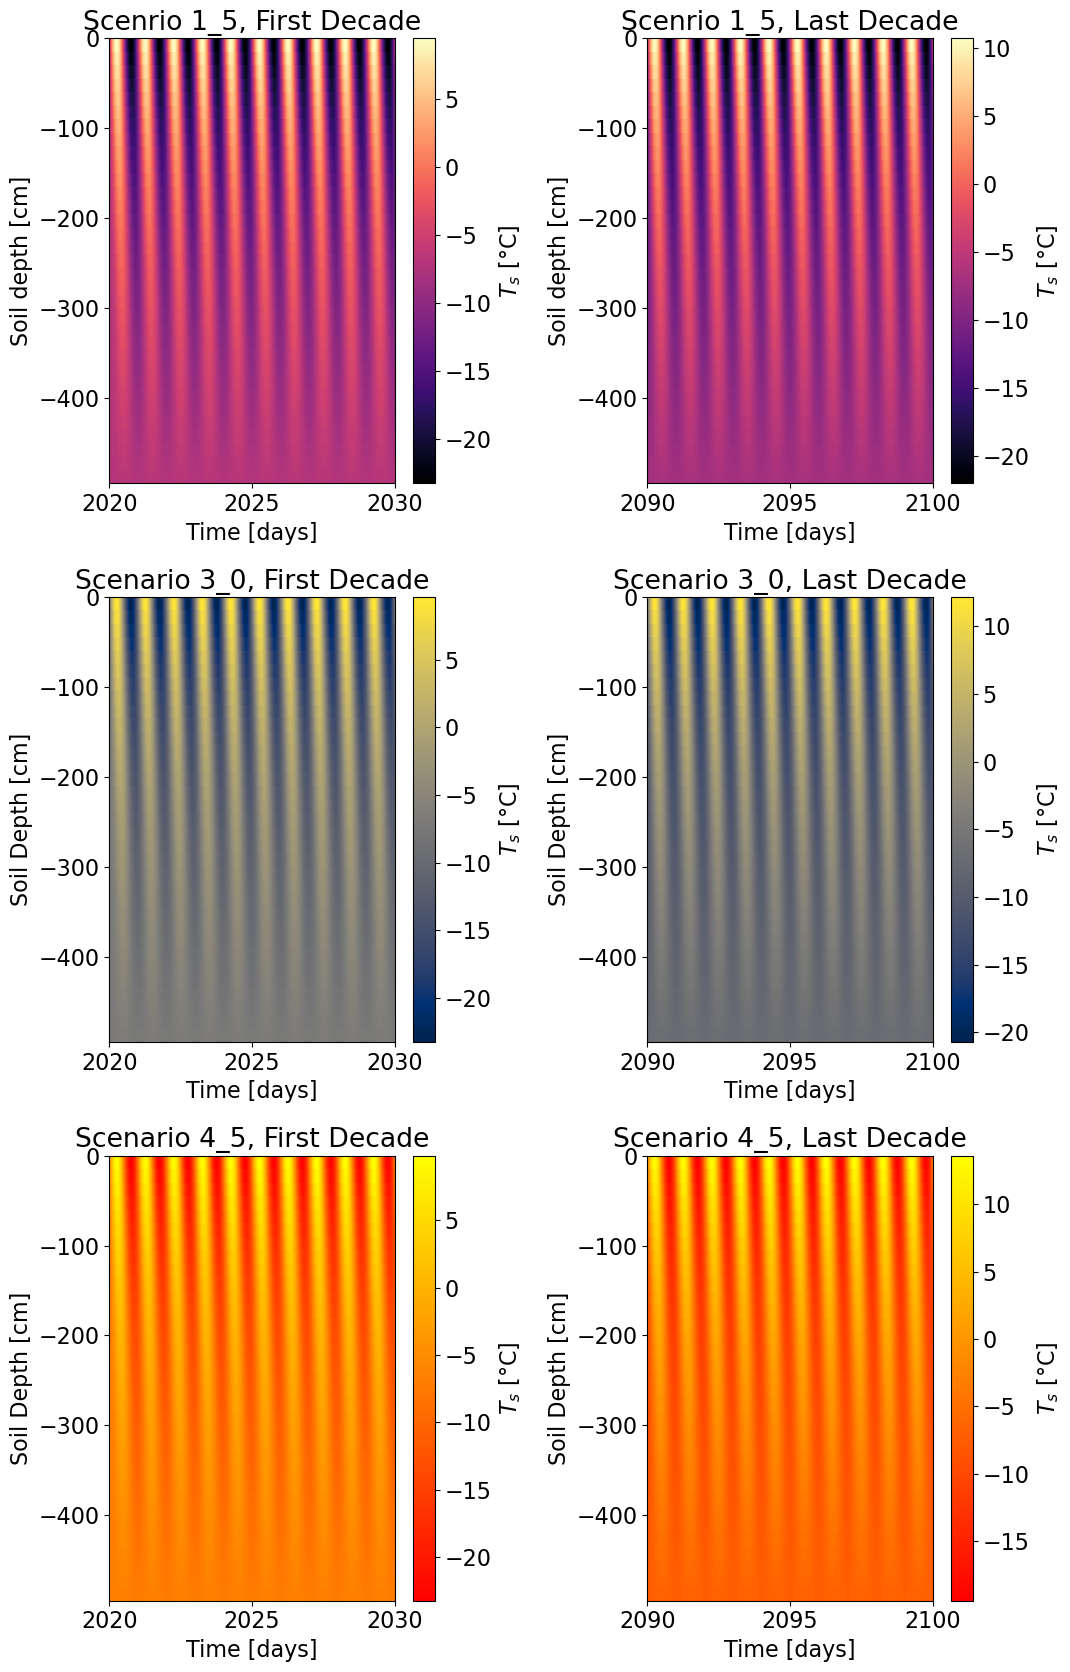

In [11]:
# temp scenrios are the rows 
# left column first 10 years, far right column is the last 10years of simulation
t_10i = t[0:14601]
t_10f = t[102200:Nt+1]

#plots equations from above from time(t) vs temp
plt.figure(figsize = (11,17))
plt.rcParams.update({'font.size': 16})

#Meshgrid returns coordinate matrices from coordinate vectors.
#Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids, 
#given one-dimensional coordinate arrays x1, x2,…, xn.

t1,z1 = np.meshgrid(t_10i,z)
t2,z2 = np.meshgrid(t_10f,z)


plt.subplot(3,2,1)
plt.pcolormesh(t1,-z1,Ts_15[:,0:14601] ,cmap='magma', shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenrio 1_5, First Decade')

plt.tight_layout() # change spacing between subplots

plt.subplot(3,2,2)
plt.pcolormesh(t2,-z2,Ts_15[:,102200:Nt+1] ,cmap='magma', shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenrio 1_5, Last Decade')

plt.tight_layout() # change spacing between subplots

# Scenario 2, 2020-2030
plt.subplot(3,2,3)
plt.pcolormesh(t1,-z1,Ts_30[:,0:14601], cmap='cividis',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 3_0, First Decade')

plt.tight_layout() # change spacing between subplots

plt.subplot(3,2,4)
plt.pcolormesh(t2,-z2,Ts_30[:,102200:Nt+1], cmap='cividis',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 3_0, Last Decade')

plt.tight_layout() # change spacing between subplots

plt.subplot(3,2,5)
plt.pcolormesh(t1,-z1,Ts_45[:,0:14601], cmap='autumn',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 4_5, First Decade')

plt.tight_layout() # change spacing between subplots

plt.subplot(3,2,6)
plt.pcolormesh(t2,-z2,Ts_45[:,102200:Nt+1], cmap='autumn',shading='auto')
plt.colorbar(label= '$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil Depth [cm]')
plt.title('Scenario 4_5, Last Decade')


plt.show()

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 


In [ ]:
# another set of plots 
# grab temp at different temps 
#


### 9. Plot Results, Analyze, and Interpret

Create plots of the following:


3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

In [ ]:
# last set of plots 
# ???create markdown table
